# Procesamiento de lenguaje natural
## Desafío 3

## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import os
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import gc


2024-06-07 00:42:21.880448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 00:42:21.977086: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 00:42:22.373011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jorge/miniconda3/envs/tensorflow/lib/:/home/jorge/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorrt/
2024-06-07 00:42:22.373079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Datos

Emplearé el libro "El señor de los anillos" preprocesado previamente.

Cada linea del archivo es una oración. Esta elección es para mejorar la generación de nuevas secuencias a través del contexto de una oración completa.

In [2]:
# Listo el directorio de los libros 
os.listdir("./libros_dataset/")

['el_senor_de_los_anillos_preprocesado.txt',
 'el_senor_de_los_anillos_procesado_oraciones.txt',
 'el_senor_de_los_anillos.txt']

In [3]:
# Armo el dataset utilizando salto de línea para separar las oraciones/docs
df_full = pd.read_csv('libros_dataset/el_senor_de_los_anillos_procesado_oraciones.txt', sep='/n', header=None)
#df_full = pd.read_csv('libros_dataset/el_senor_80.txt', sep='/n', header=None)
df_full.head()

/tmp/ipykernel_123532/1266512128.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_full = pd.read_csv('libros_dataset/el_senor_de_los_anillos_procesado_oraciones.txt', sep='/n', header=None)


,0
0,"Tolkien, JRR."
1,El Señor de los anillos.
2,La Comunidad del anillo.
3,PROLOGO.
4,De los Hobbits.


In [4]:
# Solo se utilizaré un fragmento del dataset para entrenar el modelo de lenguaje (Por cuestiones de memoria)
# Utilizaré las primeras 1000 oraciones
df = df_full.head(1000)
df.head()

,0
0,"Tolkien, JRR."
1,El Señor de los anillos.
2,La Comunidad del anillo.
3,PROLOGO.
4,De los Hobbits.


Considerare que cada secuencia para este dataset es una oración.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1000


### Elegir el tamaño del contexto

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [7]:
# cada oración lo guardo en una lista
text = list(df.loc[:,0])
text

['Tolkien, JRR.',
 'El Señor de los anillos.',
 'La Comunidad del anillo.',
 'PROLOGO.',
 'De los Hobbits.',
 'Este libro trata principalmente de los Hobbits, y el lector descubrirá en sus páginas mucho del carácter y algo de la historia de este pueblo.',
 'Podrá encontrarse más información en los extractos del Libro Rojo de la Frontera del Oeste que ya han sido publicados con el título de El Hobbit.',
 'El relato tuvo su origen en los primeros capítulos del Libro Rojo, compuesto por Bilbo Bolsón -el primer Hobbit que fue famoso en el mundo entero - y que él tituló Historia de una ida y de una vuelta, pues contaba el viaje de Bilbo hacia el Este y la vuelta, aventura que más tarde enredaría a todos los Hobbits en los importantes acontecimientos que aquí se relatan.',
 'No obstante, muchos querrán saber desde un principio algo más de este pueblo notable y quizás algunos no tengan el libro anterior.',
 'Para esos lectores se han reunido aquí algunas notas sobre los puntos más importantes

In [8]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [9]:
text[0]

'Tolkien, JRR.'

In [10]:
segmented_sentences[0]

['tolkien', 'jrr']

In [11]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([112., 225., 184., 171., 137.,  60.,  52.,  16.,   8.,  14.,   9.,
          4.,   3.,   3.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([  1.  ,   7.65,  14.3 ,  20.95,  27.6 ,  34.25,  40.9 ,  47.55,
         54.2 ,  60.85,  67.5 ,  74.15,  80.8 ,  87.45,  94.1 , 100.75,
        107.4 , 114.05, 120.7 , 127.35, 134.  ]),
 <BarContainer object of 20 artists>)

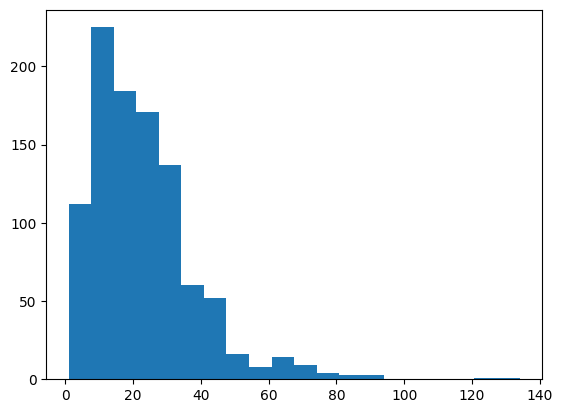

In [12]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [13]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 40


###  Tokenizar

In [14]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [15]:
tokenized_sentences[0]

[1771, 1772]

In [16]:
segmented_sentences[0]

['tolkien', 'jrr']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [18]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [19]:
len(tok_sent)

1959

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [20]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [21]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [22]:
train_seqs.shape

(62712, 41)

In [23]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [24]:
y.shape

(62712, 40)

In [25]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'y',
 3: 'la',
 4: 'que',
 5: 'en',
 6: 'los',
 7: 'el',
 8: 'a',
 9: 'se',
 10: 'no',
 11: 'un',
 12: 'lo',
 13: 'las',
 14: 'del',
 15: 'una',
 16: 'bilbo',
 17: 'con',
 18: 'más',
 19: 'por',
 20: 'pero',
 21: 'había',
 22: 'al',
 23: 'frodo',
 24: 'como',
 25: 'hobbits',
 26: 'para',
 27: 'es',
 28: 'era',
 29: 'anillo',
 30: 'me',
 31: 'dijo',
 32: 'gandalf',
 33: 'le',
 34: 'bolsón',
 35: 'o',
 36: 'su',
 37: 'comarca',
 38: 'muy',
 39: 'todo',
 40: 'todos',
 41: 'si',
 42: 'sobre',
 43: 'años',
 44: 'fue',
 45: 'aunque',
 46: 'cuando',
 47: 'eran',
 48: 'él',
 49: 'hasta',
 50: 'tiempo',
 51: 'mucho',
 52: 'ya',
 53: 'viejo',
 54: 'sin',
 55: 'habían',
 56: 'señor',
 57: 'este',
 58: 'estaba',
 59: 'pues',
 60: 'ni',
 61: 'qué',
 62: 'historia',
 63: 'ahora',
 64: 'cosas',
 65: 'bien',
 66: 'entre',
 67: 'sólo',
 68: 'mismo',
 69: 'te',
 70: 'sus',
 71: 'muchos',
 72: 'desde',
 73: 'siempre',
 74: 'tenía',
 75: 'hobbit',
 76: 'así',
 77: 'mi',
 78: 'otros',
 79: 'f

In [26]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4597

In [27]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'y': 2, 'la': 3, 'que': 4, 'en': 5, 'los': 6, 'el': 7, 'a': 8, 'se': 9, 'no': 10, 'un': 11, 'lo': 12, 'las': 13, 'del': 14, 'una': 15, 'bilbo': 16, 'con': 17, 'más': 18, 'por': 19, 'pero': 20, 'había': 21, 'al': 22, 'frodo': 23, 'como': 24, 'hobbits': 25, 'para': 26, 'es': 27, 'era': 28, 'anillo': 29, 'me': 30, 'dijo': 31, 'gandalf': 32, 'le': 33, 'bolsón': 34, 'o': 35, 'su': 36, 'comarca': 37, 'muy': 38, 'todo': 39, 'todos': 40, 'si': 41, 'sobre': 42, 'años': 43, 'fue': 44, 'aunque': 45, 'cuando': 46, 'eran': 47, 'él': 48, 'hasta': 49, 'tiempo': 50, 'mucho': 51, 'ya': 52, 'viejo': 53, 'sin': 54, 'habían': 55, 'señor': 56, 'este': 57, 'estaba': 58, 'pues': 59, 'ni': 60, 'qué': 61, 'historia': 62, 'ahora': 63, 'cosas': 64, 'bien': 65, 'entre': 66, 'sólo': 67, 'mismo': 68, 'te': 69, 'sus': 70, 'muchos': 71, 'desde': 72, 'siempre': 73, 'tenía': 74, 'hobbit': 75, 'así': 76, 'mi': 77, 'otros': 78, 'fin': 79, 'algo': 80, 'ellos': 81, 'entonces': 82, 'elfos': 83, 'yo': 84, 'algunos'

In [28]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'tolkien': 1, 'jrr': 1, 'señor': 35, 'los': 365, 'anillos': 15, 'de': 590, 'el': 410, 'la': 429, 'del': 161, 'anillo': 84, 'comunidad': 3, 'prologo': 1, 'hobbits': 105, 'descubrirá': 1, 'en': 413, 'este': 39, 'y': 569, 'historia': 36, 'principalmente': 4, 'pueblo': 8, 'carácter': 3, 'algo': 30, 'trata': 3, 'páginas': 3, 'mucho': 46, 'libro': 20, 'sus': 32, 'lector': 1, 'información': 2, 'que': 429, 'han': 6, 'más': 139, 'título': 2, 'encontrarse': 1, 'con': 148, 'sido': 19, 'frontera': 6, 'podrá': 3, 'ya': 44, 'hobbit': 33, 'oeste': 19, 'publicados': 1, 'rojo': 13, 'extractos': 1, 'famoso': 2, 'pues': 39, 'una': 159, 'tuvo': 9, 'tituló': 1, 'vuelta': 3, 'hacia': 25, 'fue': 50, 'aventura': 3, 'todos': 59, 'relatan': 1, 'se': 287, 'capítulos': 1, 'contaba': 3, 'enredaría': 1, 'bolsón': 65, 'aquí': 19, 'su': 66, 'relato': 4, 'origen': 3, 'mundo': 13, 'viaje': 7, 'por': 137, 'compuesto': 1, 'a': 335, 'primer': 6, 'importantes': 9, 'entero': 1, 'ida': 1, 'él': 44


### Definir el modelo

In [29]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))

model.add(LSTM(100, return_sequences=True))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


2024-06-07 00:42:23.496578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 00:42:23.501204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 00:42:23.501369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-07 00:42:23.501896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          229900    
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 4598)        464398    
                                                                 
Total params: 835,098
Trainable params: 835,098
Non-trainable params: 0
_________________________________________________________________


Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [31]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_word")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

        # Recolección de basura para liberar memoria
        gc.collect()


### Entrenamiento

In [32]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.

gc.collect() # liberamos memoria antes de entrenar - Esto lo hago porque me quedo sin memoria de GPU teniendo un maximo de 12GB y con CPU tarda mucho
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64) 




Epoch 1/20


2024-06-07 00:42:26.276335: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


  8/980 [..............................] - ETA: 8s - loss: 7.6490   

2024-06-07 00:42:26.822343: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


978/980 [============================>.] - ETA: 0s - loss: 2.9688

2024-06-07 00:42:35.780657: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3391484800 exceeds 10% of free system memory.



 mean perplexity: 39577.49628386001 



INFO:tensorflow:Assets written to: my_model_word/assets


INFO:tensorflow:Assets written to: my_model_word/assets


Saved new model!
980/980 [==============================] - 17s 15ms/step - loss: 2.9672
Epoch 2/20
980/980 [==============================] - ETA: 0s - loss: 1.7203

2024-06-07 00:42:49.963846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3391484800 exceeds 10% of free system memory.



 mean perplexity: 19843.167448388434 



INFO:tensorflow:Assets written to: my_model_word/assets


INFO:tensorflow:Assets written to: my_model_word/assets


Saved new model!
980/980 [==============================] - 14s 14ms/step - loss: 1.7203
Epoch 3/20
979/980 [============================>.] - ETA: 0s - loss: 1.1181

2024-06-07 00:43:04.061307: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3391484800 exceeds 10% of free system memory.



 mean perplexity: 50138.67250171287 

980/980 [==============================] - 11s 11ms/step - loss: 1.1179
Epoch 4/20
978/980 [============================>.] - ETA: 0s - loss: 0.8307

2024-06-07 00:43:14.232081: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3391484800 exceeds 10% of free system memory.



 mean perplexity: 75392.51292633062 

980/980 [==============================] - 10s 10ms/step - loss: 0.8306
Epoch 5/20
976/980 [============================>.] - ETA: 0s - loss: 0.6800

2024-06-07 00:43:25.065561: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3391484800 exceeds 10% of free system memory.



 mean perplexity: 135811.21115546962 

980/980 [==============================] - 11s 11ms/step - loss: 0.6799
Epoch 6/20
977/980 [============================>.] - ETA: 0s - loss: 0.5882
 mean perplexity: 149507.48687474118 

980/980 [==============================] - 11s 11ms/step - loss: 0.5879
Epoch 7/20
974/980 [============================>.] - ETA: 0s - loss: 0.5242
 mean perplexity: 179989.0073973584 

Stopping training...
980/980 [==============================] - 11s 11ms/step - loss: 0.5242


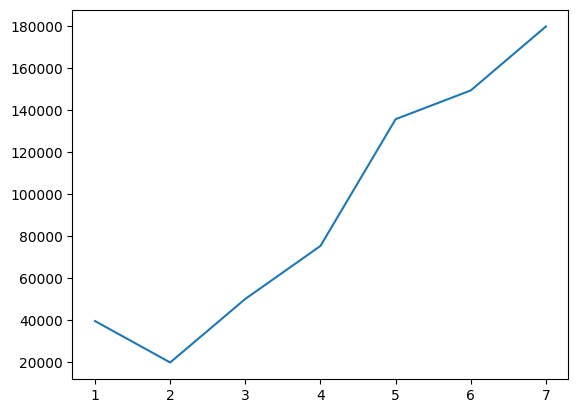

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [35]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_word')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

#!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

### Generación de secuencias

In [36]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [37]:
input_text='en una tierra muy lejana'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 12ms/step


'en una tierra muy lejana en la habilidad profesional de la tierra muy desarrollado muy'

###  Beam search y muestreo aleatorio

In [38]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [39]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [40]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="en una tierra muy lejana",temp=1,mode='sto')

In [41]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 46)

In [42]:
# veamos las salidas
decode(salidas[0])

['en una tierra muy lejana en los límites de la tierra']